# Model Risk Pipeline

This notebook aims at demonstrating how one might employ the default pipeline for ML tasks. Hyperparameter optimization relies on `hyperopt` library, we expect to add `optuna` support in the future.

__Inputs:__

1. Dataset

__Ouputs:__

1. Optimal pipeline structure, as obtained by `hyperopt`
2. Optimal model

## 1. Technicals

In [2]:
import time
import json
import numpy as np
import pandas as pd
import sklearn
from hyperopt import hp
from collections import OrderedDict
import matplotlib.pyplot as plt
import scikitplot as skplt

from modules import defaults
from modules.utils import gini_score
from modules.pipeline import PipeHPOpt

from hyperopt import fmin, tpe, STATUS_OK, STATUS_FAIL, Trials

In [3]:
seed = 42

## 2. Import Dataset

In [4]:
X_train = pd.read_parquet('../datasets/01_german/samples/X_train.parquet')
y_train = pd.read_parquet('../datasets/01_german/samples/y_train.parquet').target

X_test  = pd.read_parquet('../datasets/01_german/samples/X_test.parquet')
y_test  = pd.read_parquet('../datasets/01_german/samples/y_test.parquet').target

In [5]:
with open('../datasets/01_german/factors.json') as json_file:
    factors_dict = json.load(json_file)

## 3. Define Pipeline & Modules

### 3.1. Загрузка дефолтных параметров

Возможен выбор одного из 3 сценариев:
* `'fast'` — pipeline включает наиболее быстрые модули
* `'standard'` — pipeline включает стандартный набор модулей
* `'greedy'` — pipeline включает наиболее полный набор модулей, включая жадный отбор факторов

In [6]:
# get default modules
pipe_modules = defaults.get_default_modules()

In [7]:
fast_space = defaults.get_space('fast')
standard_space = defaults.get_space('standard')
greedy_space = defaults.get_space('greedy')

### 3.2. Подстановка оптимизационной задачи

In [8]:
# %%capture --no-stdout
# hpoptimizer = PipeHPOpt(
#     X_train, y_train,     # omly train is provided, cross-validation or train/valid is conducted automatically 
#     modules=pipe_modules, # modules employed in the pipeline
#     mode='kfold',         # kfold or valid
#     n_folds=4,            # number of cross-validation samples for 'kfold' mode
#     # test_size=.33,        # test size for 'valid' mode
#     seed=seed             # seed
# )
# lgb_opt, trials = hpoptimizer.process(space=fast_space, trials=Trials(), algo=tpe.suggest, max_evals=10)

In [9]:
%%capture --no-stdout
hpoptimizer = PipeHPOpt(modules=pipe_modules, 
                        mode='kfold', 
                        n_folds=4, 
                        seed=seed)

best_mdl, best_params, trials = hpoptimizer.train(space=standard_space, X=X_train, y=y_train, trials=Trials(), algo=tpe.suggest, max_evals=100)

100%|█████████████████████████████████████████████| 100/100 [00:54<00:00,  1.82trial/s, best loss: -0.6620048776000734]


## 4. Results Analysis

In [10]:
# hpoptimizer.get_best_params()
# best_mdl = hpoptimizer.get_best_model()

In [11]:
y_train_pred = best_mdl.predict_proba(X_train)
y_test_pred = best_mdl.predict_proba(X_test)

### 4.1. Ginis: Train vs. Test

In [12]:
gini_score(y_train, y_train_pred[:, 1])
gini_score(y_test, y_test_pred[:, 1])

Gini: 0.7017050304708319
Gini: 0.5530712826060826


0.5530712826060826

Gini: 0.7965394636242844

Gini: 0.5763913931962976

#### ROC

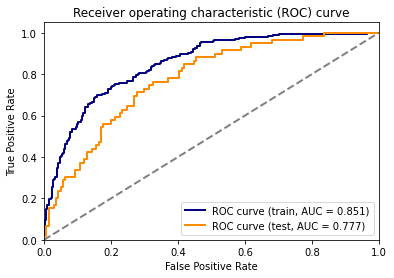

In [13]:
hpoptimizer.plot_roc(X_train, y_train, X_test, y_test, mdl=best_mdl)

#### Gain

<AxesSubplot:title={'center':'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

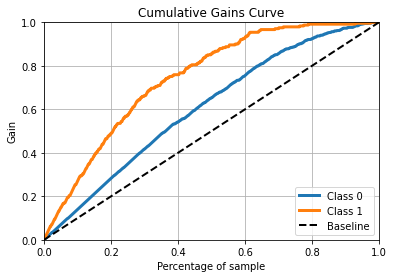

In [14]:
skplt.metrics.plot_cumulative_gain(y_train, y_train_pred)

<AxesSubplot:title={'center':'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

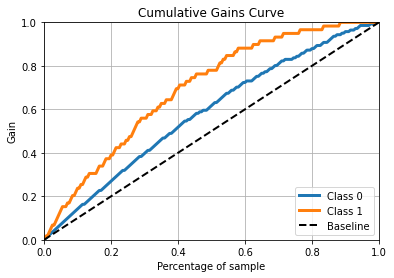

In [15]:
skplt.metrics.plot_cumulative_gain(y_test, y_test_pred)

#### Lift

<AxesSubplot:title={'center':'Lift Curve'}, xlabel='Percentage of sample', ylabel='Lift'>

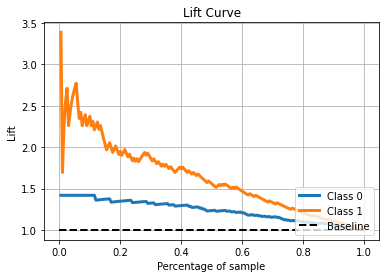

In [16]:
skplt.metrics.plot_lift_curve(y_test, y_test_pred)

#### KS Statistic

<AxesSubplot:title={'center':'KS Statistic Plot'}, xlabel='Threshold', ylabel='Percentage below threshold'>

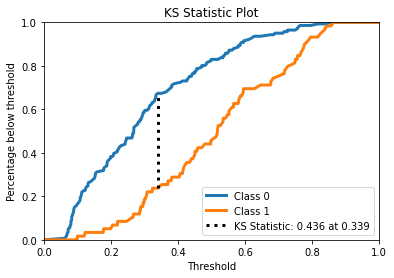

In [17]:
skplt.metrics.plot_ks_statistic(y_test, y_test_pred)

#### Precision-Recall

<AxesSubplot:title={'center':'Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>

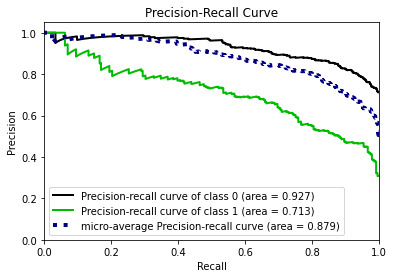

In [18]:
skplt.metrics.plot_precision_recall(y_train, y_train_pred)

<AxesSubplot:title={'center':'Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>

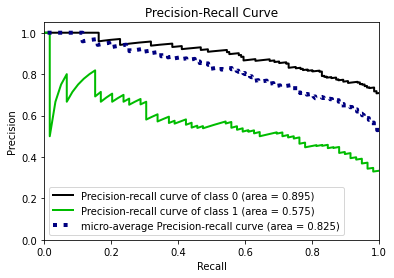

In [19]:
skplt.metrics.plot_precision_recall(y_test, y_test_pred)

### 4.2. Calibration

<AxesSubplot:title={'center':'Calibration plots (Reliability Curves)'}, xlabel='Mean predicted value', ylabel='Fraction of positives'>

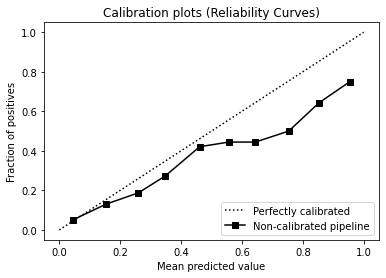

In [20]:
skplt.metrics.plot_calibration_curve(y_test,
                                     [y_test_pred],
                                     ['Non-calibrated pipeline'])

### 4.3. HyperOpt Convergence

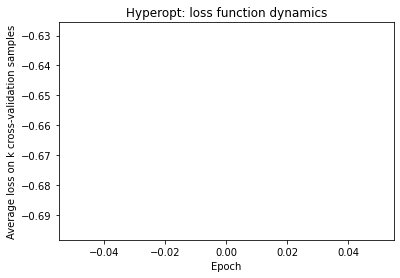

In [21]:
hpoptimizer.plot_convergence()